<a href="https://colab.research.google.com/github/mariya-kislicyna/NeuralNetworks/blob/main/LSTM_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance as yf
dataset = yf.download(tickers = 'SBER.ME', start = '2013-03-11',end = '2023-03-11')
dataset.tail(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-18,128.199997,131.300003,125.000000,125.120003,125.120003,55565940
2022-05-19,125.309998,126.860001,123.209999,125.599998,125.599998,34246550
2022-05-20,125.599998,125.599998,125.599998,125.599998,125.599998,0
2022-05-23,125.599998,125.599998,125.599998,125.599998,125.599998,0
2022-05-24,125.599998,125.599998,125.599998,125.599998,125.599998,0


In [42]:
# Добавляем индикаторы
dataset['RSI']=ta.rsi(dataset.Close, length=15)
dataset['EMAF']=ta.ema(dataset.Close, length=20)
dataset['EMAM']=ta.ema(dataset.Close, length=100)
dataset['EMAS']=ta.ema(dataset.Close, length=150)

#Закрывающая цена следующего дня, выбирается из столбца Adjusted Close со сдвигом на одну позицию вверх
dataset['TargetNextClose'] = dataset['Adj Close'].shift(-1)

#Удаление пустых значений
dataset.dropna(inplace=True)
dataset.reset_index(inplace = True)

#Удаление столбцов 'Volume', 'Close' и 'Date' из данных, т.к. они не будут использоваться
dataset.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [43]:
data = dataset.iloc[:, 0:11]
pd.set_option('display.max_columns', None)

data.head(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,101.790001,103.010002,101.050003,57.776699,60.648583,99.022317,97.218725,97.606067,58.999935
1,102.040001,104.360001,101.849998,58.999935,65.338073,99.467811,97.347067,97.686781,58.487881
2,104.000000,104.160004,102.419998,58.487881,62.023069,99.785162,97.455046,97.754506,58.601665
3,102.400002,103.000000,101.709999,58.601665,62.476353,100.091337,97.564847,97.823983,59.568886
4,103.910004,104.889999,103.519997,59.568886,66.155338,100.530257,97.706137,97.915056,59.193378


In [44]:
from sklearn.preprocessing import MinMaxScaler
#Нормализация данных
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(data)
print(scaled_data)

[[0.14646677 0.14296881 0.16339414 ... 0.11002347 0.10810842 0.07712023]
 [0.14721788 0.147027   0.16582198 ... 0.1104983  0.10842316 0.07568036]
 [0.15310659 0.1464258  0.16755182 ... 0.1108978  0.10868724 0.07600032]
 ...
 [0.21713134 0.21466363 0.2306455  ... 0.49982659 0.61865748 0.26439578]
 [0.21800263 0.21087597 0.23789869 ... 0.494187   0.61334106 0.26439578]
 [0.21800263 0.21087597 0.23789869 ... 0.48865908 0.60809506 0.26439578]]


In [45]:
# Список X  будет содержать признаки для обучения модели
X = []
# Количество свечей/дней, которые хотим посмотреть в прошлом, чтобы предсказать закрывающую цену на завтра
backcandles = 30
print(scaled_data.shape[0])
for j in range(8):# кол-во столбцов scaled_data), последний столбец - таргет
    X.append([])
    for i in range(backcandles, scaled_data.shape[0]):# backcandles+2
        X[j].append(scaled_data[i-backcandles:i, j])

# Меняется ось массива с 0 на позицию 2 для соответствия ожидаемому формату входных данных модели
X=np.moveaxis(X, [0], [2])

# Массив yi содержит значения закрывающих цен
X, yi =np.array(X), np.array(scaled_data[backcandles:,-1])
# Получаем из yi столбцовый вектор
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

2143
[[[0.14646677 0.14296881 0.16339414 ... 0.12697323 0.11002347 0.10810842]
  [0.14721788 0.147027   0.16582198 ... 0.12843651 0.1104983  0.10842316]
  [0.15310659 0.1464258  0.16755182 ... 0.12947889 0.1108978  0.10868724]
  ...
  [0.15307654 0.15057417 0.17113289 ... 0.14021305 0.11956786 0.11495414]
  [0.15731282 0.15436182 0.17659556 ... 0.14120371 0.12003832 0.11530835]
  [0.158785   0.1529189  0.17571546 ... 0.1420312  0.12048334 0.11564652]]

 [[0.14721788 0.147027   0.16582198 ... 0.12843651 0.1104983  0.10842316]
  [0.15310659 0.1464258  0.16755182 ... 0.12947889 0.1108978  0.10868724]
  [0.14829948 0.14293874 0.1653971  ... 0.13048457 0.11130404 0.10895816]
  ...
  [0.15731282 0.15436182 0.17659556 ... 0.14120371 0.12003832 0.11530835]
  [0.158785   0.1529189  0.17571546 ... 0.1420312  0.12048334 0.11564652]
  [0.15644153 0.15063428 0.17444085 ... 0.14245768 0.12084409 0.115927  ]]

 [[0.15310659 0.1464258  0.16755182 ... 0.12947889 0.1108978  0.10868724]
  [0.14829948 0.1

In [47]:
#Разделим данные на обучающую и тестовую выборки
split_limit = int(len(X)*0.8)
print(split_limit)
X_train, X_test = X[:split_limit], X[split_limit:]
y_train, y_test = y[:split_limit], y[split_limit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1690
(1690, 30, 8)
(423, 30, 8)
(1690, 1)
(423, 1)
[[0.07936002]
 [0.07955201]
 [0.07656026]
 ...
 [0.47329783]
 [0.47341934]
 [0.47281182]]


In [48]:
import tensorflow as tf
import keras
import numpy as np

from keras import optimizers
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.callbacks import History

np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
102/102 [==============================] - 7s 52ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 2/30
102/102 [==============================] - 3s 32ms/step - loss: 2.7375e-04 - val_loss: 0.0032
Epoch 3/30
102/102 [==============================] - 3s 33ms/step - loss: 2.0763e-04 - val_loss: 0.0022
Epoch 4/30
102/102 [==============================] - 4s 41ms/step - loss: 1.8175e-04 - val_loss: 0.0027
Epoch 5/30
102/102 [==============================] - 4s 39ms/step - loss: 1.9999e-04 - val_loss: 0.0023
Epoch 6/30
102/102 [==============================] - 3s 33ms/step - loss: 1.6515e-04 - val_loss: 0.0028
Epoch 7/30
102/102 [==============================] - 3s 33ms/step - loss: 1.5112e-04 - val_loss: 0.0022
Epoch 8/30
102/102 [==============================] - 5s 49ms/step - loss: 1.5693e-04 - val_loss: 8.8454e-04
Epoch 9/30
102/102 [==============================] - 3s 34ms/step - loss: 1.3600e-04 - val_loss: 0.0011
Epoch 10/30
102/102 [==============================] - 

In [49]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

14/14 [==============================] - 1s 14ms/step
[0.45903254] [0.46377183]
[0.45912105] [0.46491401]
[0.45263883] [0.46250818]
[0.45135242] [0.46090428]
[0.44940943] [0.45993231]
[0.4476249] [0.4635288]
[0.44658506] [0.45198583]
[0.4495491] [0.44389364]
[0.44091907] [0.44707703]
[0.43263847] [0.44826783]


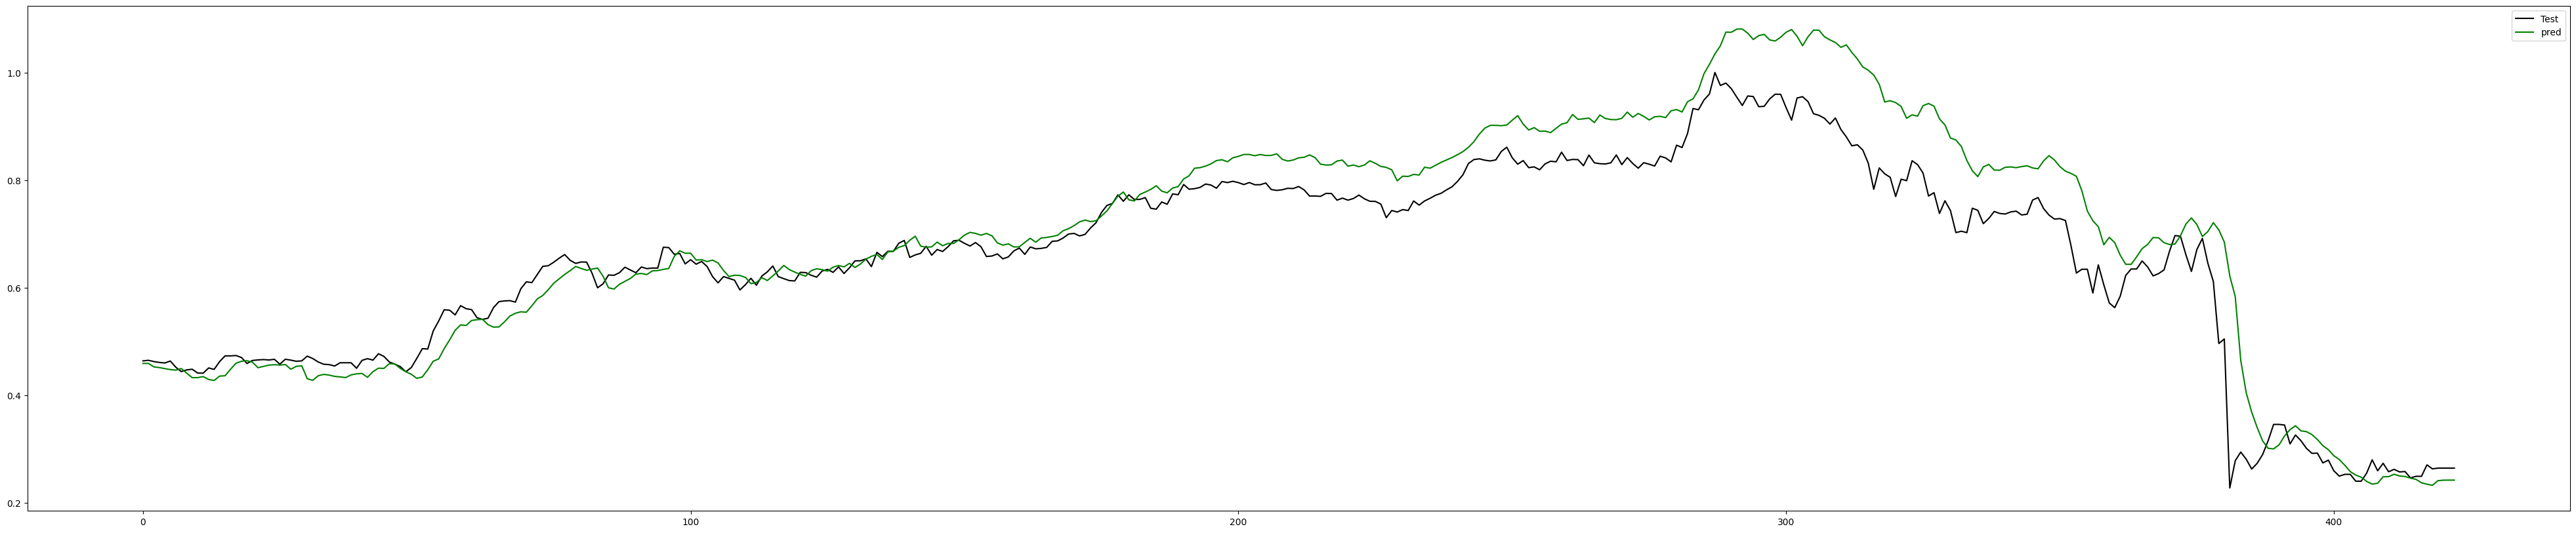

In [56]:
plt.figure(figsize=(50,10))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 30, 8)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               95400     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________
